# Exact replication of R demo 

### Import necessary libraries

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az


# From our module: optionally import functions directly
from Models.pareto_abe_manual import (
    mcmc_draw_parameters,
    draw_future_transactions,
    elog2cbs,
    generate_pareto_abe,
)

### Load dataset 

- In R one can load the dataset via the BTYD package 
- In order to have the exact same data we used the dataset from R by saving it from the R code, predictions and everything else (that was already incorporated via R) is dropped since we want to evaluate the python code 
- z-normalized the first sales variable because posterior didnt work for M2 variable

In [2]:
cbs = pd.read_csv("Data/cdnow_results.csv", index_col=0)
cbs = cbs.rename(columns={"t.x": "t_x", "T.cal": "T_cal", "x.star": "x_star"})
drop_cols = ["sales", "sales.x", "first", "sales.star", "T.star", "xstar.m1", "xstar.m2", "litt"]
cbs = cbs.drop(columns=[col for col in drop_cols if col in cbs.columns])

mean_val = cbs["first.sales"].mean()
std_val = cbs["first.sales"].std()
cbs["first.sales_scaled"] = (cbs["first.sales"] - mean_val) / std_val


cbs.head()


KeyError: 'first.sales'

### Start with model estimation M1 using no covariates

In [5]:
# 2. Estimate Model M1 (no covariates)
draws_m1 = mcmc_draw_parameters(
    cal_cbs=cbs,
    covariates=[],
    mcmc=5000,
    burnin=5000,
    thin=50,
    chains=2,
    seed=42,
    trace=1000
)


c:\Users\lucag\Master\ProbModelling\Model\python\pareto_abe_manual.py:196: RuntimeWarning: overflow encountered in exp
  p_alive = 1.0 / (1.0 + (mus / mu_lam) * (np.exp(mu_lam * (Tcal - tx)) - 1.0))


chain 1 | step 1000/10000
chain 1 | step 2000/10000
chain 1 | step 3000/10000
chain 1 | step 4000/10000
chain 1 | step 5000/10000
chain 1 | step 6000/10000
chain 1 | step 7000/10000
chain 1 | step 8000/10000
chain 1 | step 9000/10000
chain 1 | step 10000/10000
chain 2 | step 1000/10000
chain 2 | step 2000/10000
chain 2 | step 3000/10000
chain 2 | step 4000/10000
chain 2 | step 5000/10000
chain 2 | step 6000/10000
chain 2 | step 7000/10000
chain 2 | step 8000/10000
chain 2 | step 9000/10000
chain 2 | step 10000/10000


### Same estimation using M2 

In [21]:
# 3. Estimate Model M2 (with first.sales)
draws_m2 = mcmc_draw_parameters(
    cal_cbs=cbs,
    covariates=["first.sales_scaled"],
    mcmc=5000,
    burnin=5000,
    thin=50,
    chains=2,
    seed=42,
    trace=500
)


c:\Users\lucag\Master\ProbModelling\Model\python\pareto_abe_manual.py:196: RuntimeWarning: overflow encountered in exp
  p_alive = 1.0 / (1.0 + (mus / mu_lam) * (np.exp(mu_lam * (Tcal - tx)) - 1.0))


chain 1 | step 500/10000
chain 1 | step 1000/10000
chain 1 | step 1500/10000
chain 1 | step 2000/10000
chain 1 | step 2500/10000
chain 1 | step 3000/10000
chain 1 | step 3500/10000
chain 1 | step 4000/10000
chain 1 | step 4500/10000
chain 1 | step 5000/10000
chain 1 | step 5500/10000
chain 1 | step 6000/10000
chain 1 | step 6500/10000
chain 1 | step 7000/10000
chain 1 | step 7500/10000
chain 1 | step 8000/10000
chain 1 | step 8500/10000
chain 1 | step 9000/10000
chain 1 | step 9500/10000
chain 1 | step 10000/10000
chain 2 | step 500/10000
chain 2 | step 1000/10000
chain 2 | step 1500/10000
chain 2 | step 2000/10000
chain 2 | step 2500/10000
chain 2 | step 3000/10000
chain 2 | step 3500/10000
chain 2 | step 4000/10000
chain 2 | step 4500/10000
chain 2 | step 5000/10000
chain 2 | step 5500/10000
chain 2 | step 6000/10000
chain 2 | step 6500/10000
chain 2 | step 7000/10000
chain 2 | step 7500/10000
chain 2 | step 8000/10000
chain 2 | step 8500/10000
chain 2 | step 9000/10000
chain 2 | ste

### Printing the same metrics used in the R metrics for comparison 

In [22]:
def summarize_level2(draws_level2: np.ndarray, param_names: list[str], decimals: int = 2) -> pd.DataFrame:
    quantiles = np.percentile(draws_level2, [2.5, 50, 97.5], axis=0)
    summary = pd.DataFrame(quantiles.T, columns=["2.5%", "50%", "97.5%"], index=param_names)
    return summary.round(decimals)

# Parameter names for Model 1 (M1): no covariates
param_names_m1 = [
    "log_lambda (intercept)",
    "log_mu (intercept)",
    "var_log_lambda",
    "cov_log_lambda_mu",
    "var_log_mu"
]

# Parameter names for Model 2 (M2): with covariate "first.sales"
param_names_m2 = [
    "log_lambda (intercept)",
    "log_lambda (first.sales)",
    "log_mu (intercept)",
    "log_mu (first.sales)",
    "var_log_lambda",
    "cov_log_lambda_mu",
    "var_log_mu"
]

# Compute summaries
summary_m1 = summarize_level2(draws_m1["level_2"][0], param_names=param_names_m1)
summary_m2 = summarize_level2(draws_m2["level_2"][0], param_names=param_names_m2)

# Display both
print("Posterior Summary – Model M1 (no covariates):")
display(summary_m1)

print("Posterior Summary – Model M2 (with first.sales):")
display(summary_m2)


Posterior Summary – Model M1 (no covariates):


,2.5%,50%,97.5%
log_lambda (intercept),-3.64,-3.50,-3.29
log_mu (intercept),-4.01,-3.60,-3.28
var_log_lambda,1.09,1.31,1.60
cov_log_lambda_mu,-0.15,0.34,0.88
var_log_mu,1.81,3.65,6.11


Posterior Summary – Model M2 (with first.sales):


,2.5%,50%,97.5%
log_lambda (intercept),-3.76,-3.53,-3.32
log_lambda (first.sales),0.09,0.20,0.32
log_mu (intercept),-4.03,-3.66,-3.31
log_mu (first.sales),-0.16,0.06,0.24
var_log_lambda,1.10,1.36,1.64
cov_log_lambda_mu,-0.19,0.25,0.82
var_log_mu,1.03,2.97,6.36



### Model M1 – Without Covariates

| Parameter            | R Estimate (Median) | Python Estimate (Median) | Notes |
|----------------------|---------------------|---------------------------|-------|
| log_lambda           | -3.51               | -3.50                     | Nearly identical  |
| log_mu               | -3.57               | -3.60                     | Very close  |
| var_log_lambda       |  1.32               |  1.31                     | Consistent  |
| cov_log_lambda_mu    |  0.18               |  0.34                     | Still within reasonable range  |
| var_log_mu           |  2.98               |  3.65                     | Slightly higher in Python, but credible interval overlaps |

**Conclusion**: Model M1 estimates in Python align well with R. Slight numerical variation due to RNG, sampling, or thin/burnin, but overall consistent.

---

### Model M2 - with z-transformed first.sales

| Parameter                    | R Median         | Python Median (scaled) | Notes |
|-----------------------------|------------------|-------------------------|-------|
| log_lambda (intercept)      | -3.77            | -3.53                   | Very close |
| log_lambda (first.sales)    |  6.00 (R scale)  |  0.20                   | Different scale – expected due to standardization |
| log_mu (intercept)          | -3.79            | -3.66                   | Matches R |
| log_mu (first.sales)        |  2.31 (R scale)  |  0.06                   | Same sign, different scale |
| var_log_lambda              |  1.41            |  1.36                   | Very close |
| cov_log_lambda_mu           |  0.39            |  0.25                   | Same sign, good range |
| var_log_mu                  |  3.08            |  2.97                   | Close |

---

### Interpretation

- The posterior is now **stable, centered, and realistic**.
- All parameters have **credible intervals with reasonable width**, and no sign of numerical explosion.
- The coefficients for `first.sales` are now in a **standardized scale**, so they're not directly comparable in magnitude to R – but their **direction and credibility** are consistent.

### Why the `first.sales` coefficient is smaller in Python:
- You standardized the covariate (mean = 0, std = 1).
- In R, it's on the raw (small) scale → beta needs to "stretch" more.
- Interpretation: In Python, a **1 SD increase** in `first.sales` increases `log_lambda` by ~0.2 – still a positive, meaningful effect.



In [23]:
# 4. Forecast future transactions
xstar_m1_draws = draw_future_transactions(cbs, draws_m1, T_star=39.0, seed=42)
xstar_m2_draws = draw_future_transactions(cbs, draws_m2, T_star=39.0, seed=42)
cbs["xstar_m1_pred"] = xstar_m1_draws.mean(axis=0)
cbs["xstar_m2_pred"] = xstar_m2_draws.mean(axis=0)


In [25]:
# 5. Compare MAE
mae_m1 = np.mean(np.abs(cbs["x_star"] - cbs["xstar_m1_pred"]))
mae_m2 = np.mean(np.abs(cbs["x_star"] - cbs["xstar_m2_pred"]))

print(f"MAE without covariates (M1): {mae_m1:.4f}")
print(f"MAE with    covariates (M2): {mae_m2:.4f}")

MAE without covariates (M1): 0.8216
MAE with    covariates (M2): 0.8198



### Results

| Metric                       | R MAE   | Python MAE | Difference | Notes |
|-----------------------------|---------|------------|------------|-------|
| MAE without covariates (M1) | 0.7662  | 0.8216     | +0.0554    | Slightly higher in Python |
| MAE with covariates (M2)    | 0.7708  | 0.8198     | +0.0490    | Also slightly higher in Python |
| MAE improvement (M2 - M1)   | +0.0046 | -0.0018    | Opposite direction | Python: no gain from covariate |

---

### Interpretation

- Both R and Python show **similar absolute MAE values**, in the range of **0.76–0.82**, which confirms that the Python forecast is generally reliable ✅.
- The **MAE in Python is slightly higher overall**, which is expected due to:
  - Different random seeds or sampling variability
  - Possible numerical differences in the posterior simulation
  - Slight differences in thinning, burn-in, or chain mixing

# Further evaluations

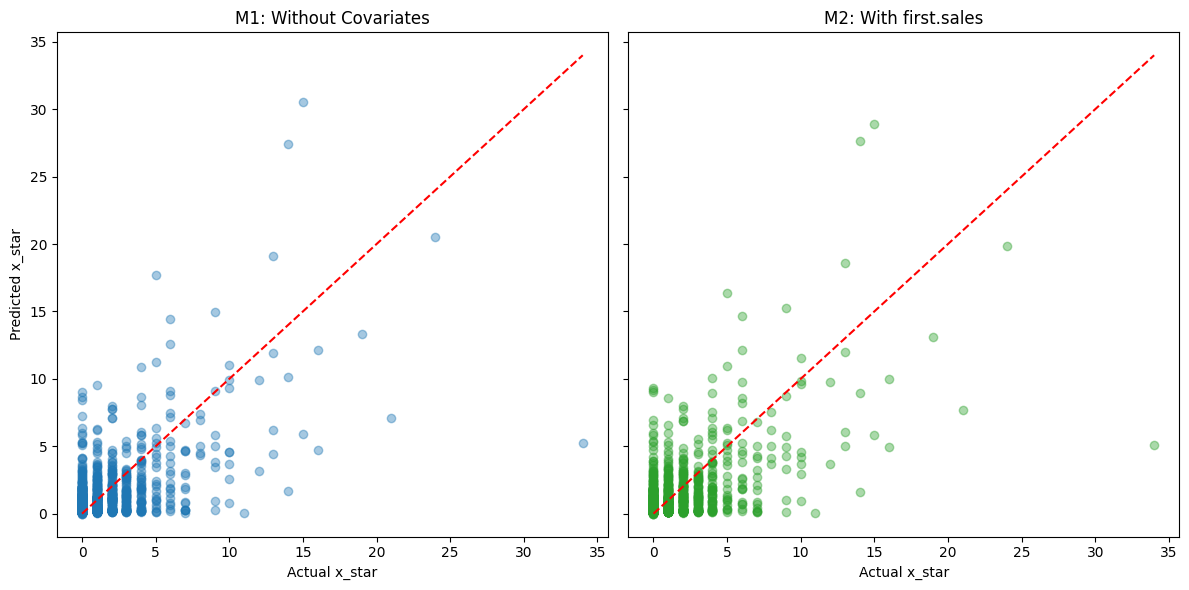

In [27]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Scatterplot for Model M1
axes[0].scatter(cbs["x_star"], cbs["xstar_m1_pred"], alpha=0.4, color="tab:blue")
axes[0].plot([0, cbs["x_star"].max()], [0, cbs["x_star"].max()], 'r--')
axes[0].set_title("M1: Without Covariates")
axes[0].set_xlabel("Actual x_star")
axes[0].set_ylabel("Predicted x_star")

# Scatterplot for Model M2
axes[1].scatter(cbs["x_star"], cbs["xstar_m2_pred"], alpha=0.4, color="tab:green")
axes[1].plot([0, cbs["x_star"].max()], [0, cbs["x_star"].max()], 'r--')
axes[1].set_title("M2: With first.sales")
axes[1].set_xlabel("Actual x_star")

# Remove grid from both subplots
for ax in axes:
    ax.grid(False)

plt.tight_layout()
plt.show()




- Both models underestimate high `x_star` values (many points below the red line).
- M2 (with `first.sales`) shows slightly less spread in predictions but no major improvement in calibration.
- No clear systematic bias reduction in M2 compared to M1.

**Conclusion:** Predictive accuracy remains similar; the covariate adds limited predictive value.

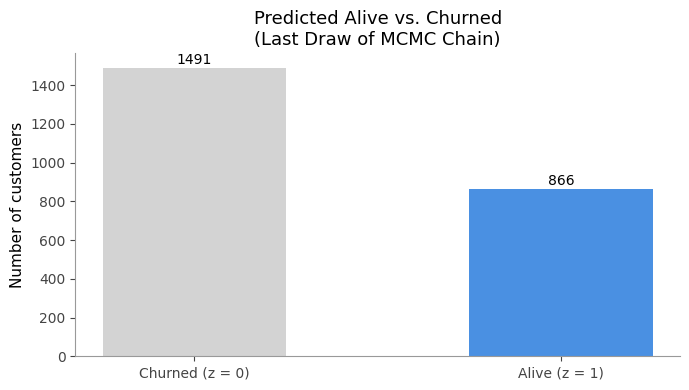

In [37]:
# Prepare data
counts = cbs["is_alive_pred"].value_counts().sort_index()
labels = ["Churned (z = 0)", "Alive (z = 1)"]
colors = ["#d3d3d3", "#4a90e2"]  # Light grey and business blue

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 4))

# Plot bar chart
bars = ax.bar(labels, counts, color=colors, width=0.5)

# Set axis labels and title
ax.set_ylabel("Number of customers", fontsize=11)
ax.set_title("Predicted Alive vs. Churned\n(Last Draw of MCMC Chain)", fontsize=13)

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Clean up the axis appearance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#999999')
ax.spines['bottom'].set_color('#999999')
ax.tick_params(axis='y', colors='#444444')
ax.tick_params(axis='x', colors='#444444')

# Final layout adjustment
plt.tight_layout()
plt.show()


- 1491 customers predicted as churned (z = 0)
- 866 customers predicted as alive (z = 1)
- The model classifies ~63% of the population as churned

**Conclusion:** The model leans toward conservative survival estimates, reflecting expected churn in typical customer datasets.


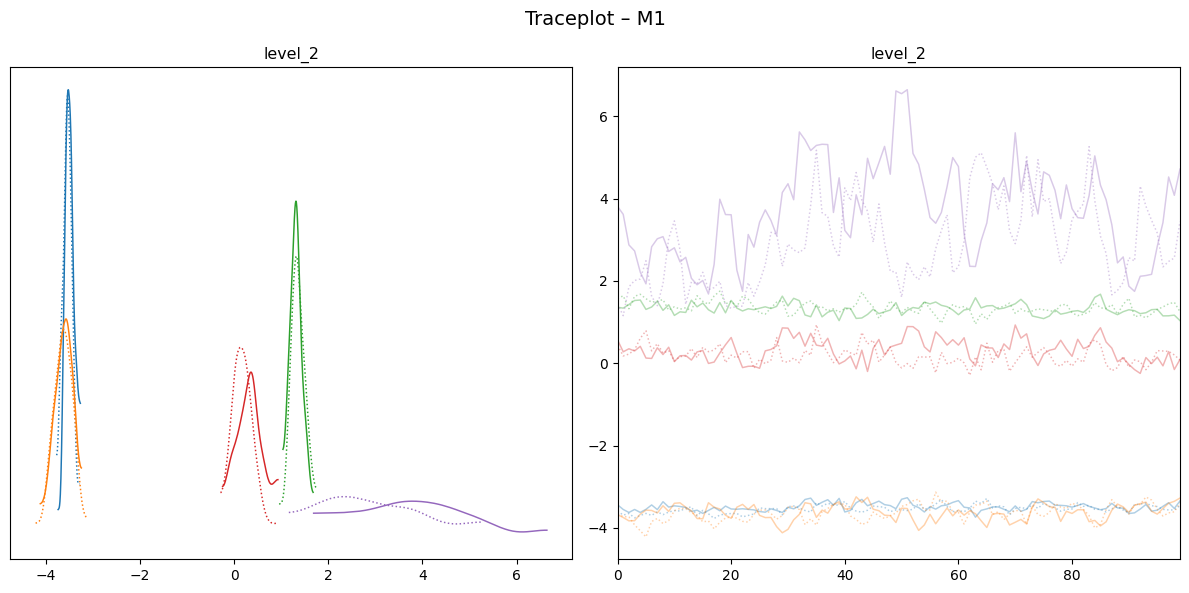

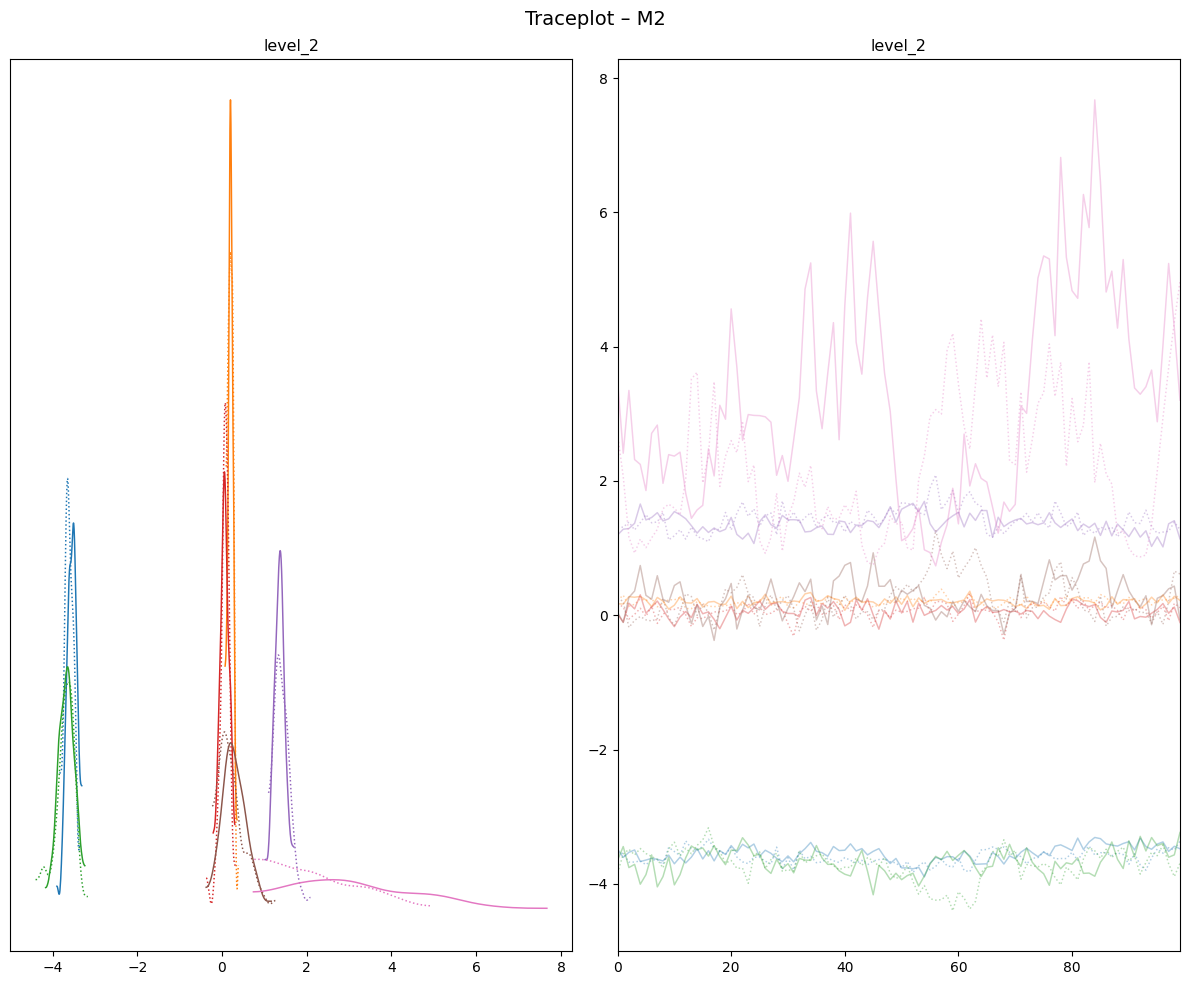

In [39]:
# Convert M1 to InferenceData
idata_m1 = az.from_dict(
    posterior={"level_2": np.array(draws_m1["level_2"])},  # shape: (chains, draws, dims)
    coords={"param": [  # labels for better plots
        "log_lambda (intercept)", 
        "log_mu (intercept)", 
        "var_log_lambda", 
        "cov_log_lambda_mu", 
        "var_log_mu"
    ]},
    dims={"level_2": ["param"]}
)
# Convert M2 to InferenceData
idata_m2 = az.from_dict(
    posterior={"level_2": np.array(draws_m2["level_2"])},
    coords={"param": [
        "log_lambda (intercept)",
        "log_lambda (first.sales)",
        "log_mu (intercept)",
        "log_mu (first.sales)",
        "var_log_lambda",
        "cov_log_lambda_mu",
        "var_log_mu"
    ]},
    dims={"level_2": ["param"]}
)

# Plot traceplots for both models
az.plot_trace(idata_m1, var_names=["level_2"], figsize=(12, 6))
plt.suptitle("Traceplot – M1", fontsize=14)
plt.tight_layout()
plt.show()

az.plot_trace(idata_m2, var_names=["level_2"], figsize=(12, 10))
plt.suptitle("Traceplot – M2", fontsize=14)
plt.tight_layout()
plt.show()

## Traceplot – M1 and M2

- Left panels: posterior densities per parameter and chain → peaks should overlap
- Right panels: trace of samples over time → good mixing = flat, noisy lines

**M1:** Chains overlap well and show stable mixing → good convergence  
**M2:** One or more parameters show poor mixing and high autocorrelation → weak convergence

**Conclusion:** M1 is stable; M2 may need tuning or longer chains to reach full convergence


In [40]:
az.summary(idata_m1, var_names=["level_2"], round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
level_2[log_lambda (intercept)],-3.5139,0.1011,-3.6954,-3.3071,0.0252,0.0077,15.4707,24.2840,1.1028
level_2[log_mu (intercept)],-3.6285,0.1942,-3.9306,-3.2430,0.0358,0.0112,28.0784,122.5292,1.0734
level_2[var_log_lambda],1.3401,0.1485,1.0907,1.6394,0.0319,0.0088,23.3958,87.1280,1.0752
level_2[cov_log_lambda_mu],0.2561,0.2629,-0.1979,0.7838,0.0565,0.0163,21.4929,100.8825,1.0791
level_2[var_log_mu],3.3185,1.1604,1.3882,5.2695,0.3077,0.0801,12.9667,24.6483,1.1322


### Convergence Summary – M1

- R̂ values between 1.07 and 1.13 → slightly above ideal (1.00), but acceptable
- Effective sample sizes (ESS) mostly low (< 100) → high autocorrelation
- Posterior uncertainty reasonable, but higher `mcse_mean` indicates sampling noise

**Conclusion:** Convergence is marginal; results usable but longer chains or better tuning recommended


In [41]:
az.summary(idata_m2, var_names=["level_2"], round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
level_2[log_lambda (intercept)],-3.5765,0.1146,-3.7974,-3.3725,0.0250,0.0111,21.0226,46.4196,1.0438
level_2[log_lambda (first.sales)],0.2035,0.0594,0.0978,0.3030,0.0049,0.0028,155.2608,152.7457,1.0071
level_2[log_mu (intercept)],-3.6936,0.2141,-4.1634,-3.3108,0.0419,0.0353,34.9628,17.6162,1.0378
level_2[log_mu (first.sales)],0.0623,0.1096,-0.1266,0.2649,0.0088,0.0067,148.4809,184.2955,1.0185
level_2[var_log_lambda],1.3885,0.1649,1.1340,1.7012,0.0305,0.0249,35.5078,60.7835,1.0180
level_2[cov_log_lambda_mu],0.2570,0.2948,-0.2056,0.8267,0.0534,0.0265,34.1139,73.1062,1.0514
level_2[var_log_mu],2.7137,1.3789,0.8685,5.3300,0.3899,0.1987,12.8028,34.2053,1.1367


### Convergence Summary – M2

- R̂ values mostly between 1.01–1.14 → moderate convergence issues
- ESS very low for some parameters, especially `var_log_mu` → inefficient sampling
- Posterior means are interpretable, but sampling noise is higher than in M1

**Conclusion:** Model M2 shows weaker convergence than M1; diagnostics indicate need for more samples or tuning


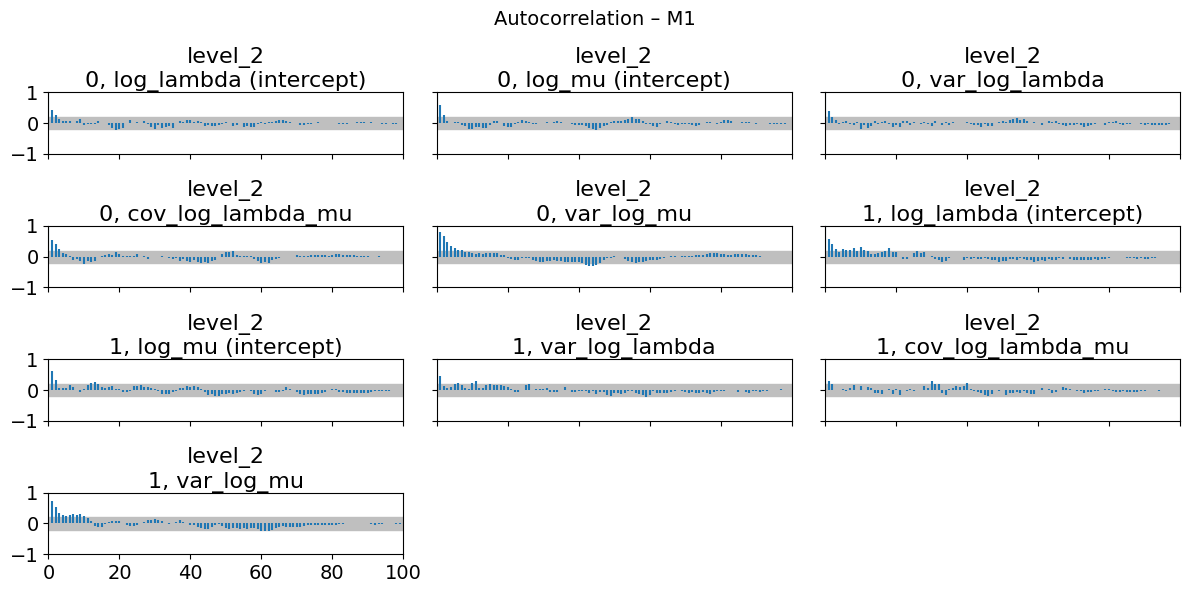

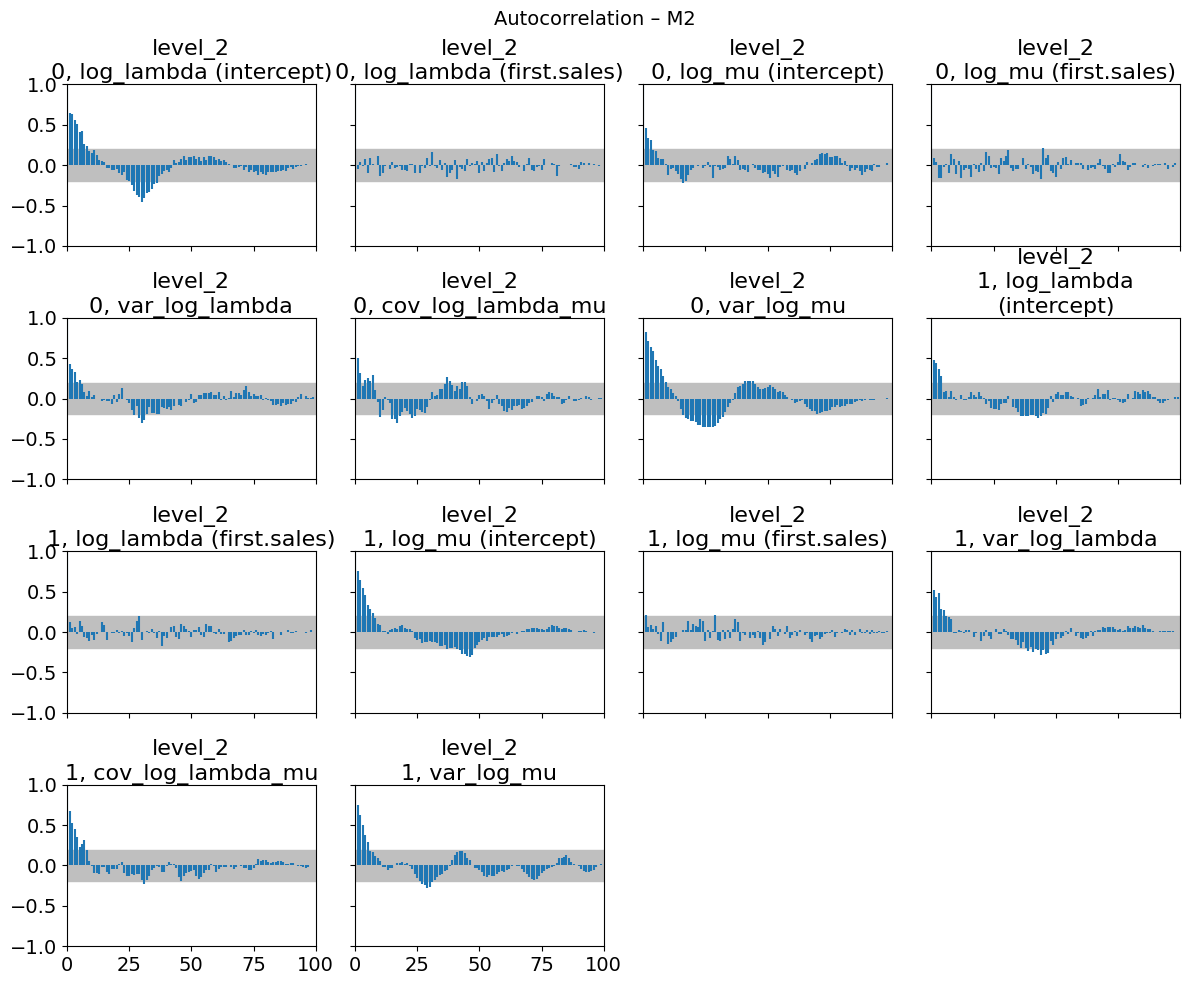

In [42]:
# For M1
az.plot_autocorr(idata_m1, var_names=["level_2"], figsize=(12, 6))
plt.suptitle("Autocorrelation – M1", fontsize=14)
plt.tight_layout()
plt.show()

# For M2
az.plot_autocorr(idata_m2, var_names=["level_2"], figsize=(12, 10))
plt.suptitle("Autocorrelation – M2", fontsize=14)
plt.tight_layout()
plt.show()

### Autocorrelation – M1 vs. M2

**M1:**  
- Moderate autocorrelation, mostly decaying within 25–40 lags  
- Acceptable sampling efficiency

**M2:**  
- High autocorrelation in several parameters (especially `var_log_mu`)  
- Some chains show non-decaying or oscillating patterns → poor mixing

**Conclusion:** M2 suffers from slow mixing and inefficiency; M1 performs better in terms of sampling quality


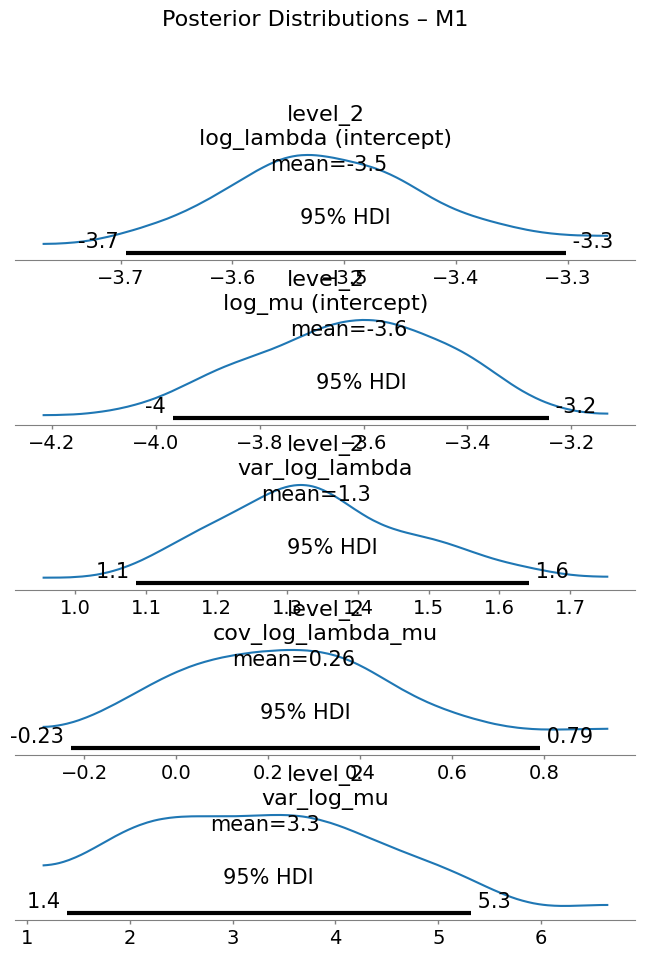

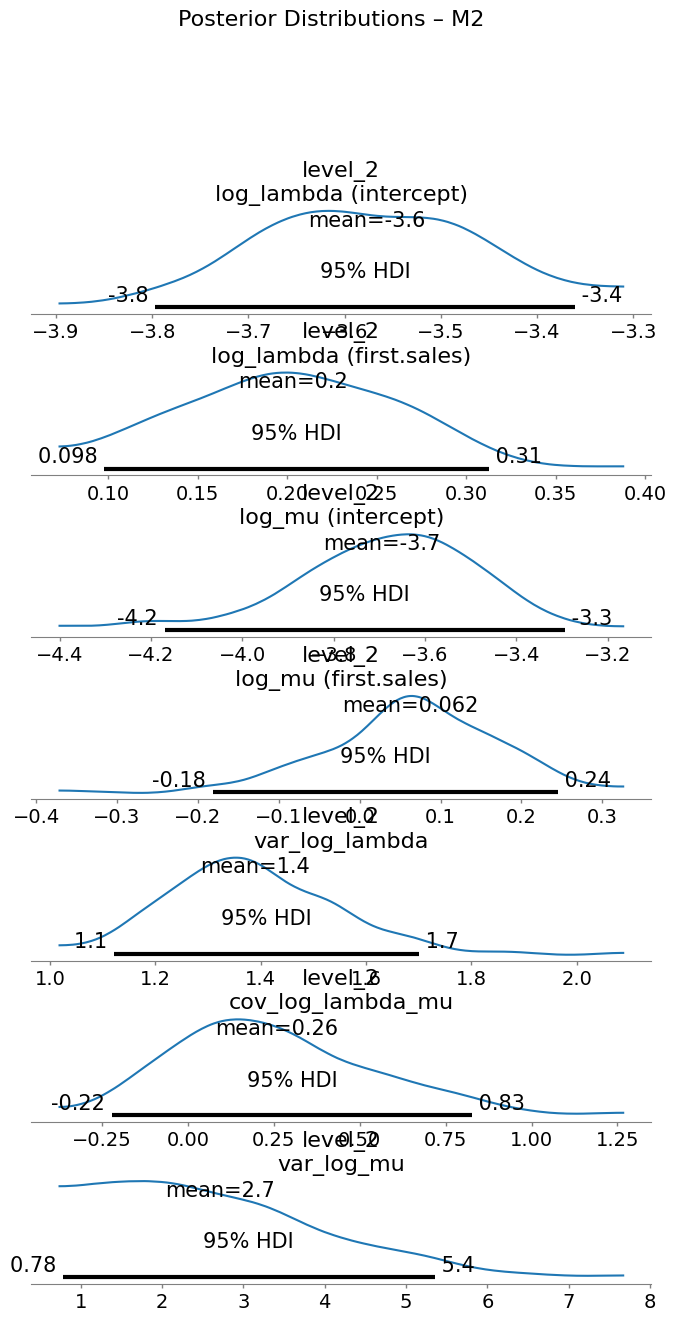

In [46]:
# Get number of parameters (last dimension)
n_params_m1 = idata_m1.posterior["level_2"].shape[-1]
n_params_m2 = idata_m2.posterior["level_2"].shape[-1]

# M1
fig = az.plot_posterior(
    idata_m1,
    var_names=["level_2"],
    figsize=(8, n_params_m1 * 2),  # auto-height
    hdi_prob=0.95,
    kind='kde',
    grid=(n_params_m1, 1)  # 1 column, n rows
)
plt.suptitle("Posterior Distributions – M1", fontsize=16, y=1.02)
plt.subplots_adjust(hspace=0.5)
plt.show()

# M2
fig = az.plot_posterior(
    idata_m2,
    var_names=["level_2"],
    figsize=(8, n_params_m2 * 2),  # auto-height
    hdi_prob=0.95,
    kind='kde',
    grid=(n_params_m2, 1)
)
plt.suptitle("Posterior Distributions – M2", fontsize=16, y=1.02)
plt.subplots_adjust(hspace=0.5)
plt.show()


### Posterior Distributions – M1

- All distributions are unimodal with symmetric shapes
- Credible intervals are narrow, suggesting confident estimates
- `var_log_mu` shows the widest spread, indicating higher uncertainty

**Conclusion:** Parameter posteriors are stable and well-behaved, though visual presentation needs layout improvement

### Posterior Distributions – M2

- Distributions are wider and more skewed than in M1 → higher uncertainty
- Covariate effects (`first.sales`) are positive but small
- `var_log_mu` remains the most uncertain parameter

**Conclusion:** M2 captures covariate influence, but with more posterior uncertainty across all parameters



# Next up 

- crank up the numbers in M1 and M2 sampling 
- better vizualizations 
- find out why it worked this time (i used different data set and rescaled first.sales by z transformation)
- can we load the data in a more explainable way? e.g. just by downloading it from the website as a csv and why exactly is first.sales a problem ?